# Upwelling analysis

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import yaml
from cmocean import cm as cmocean
from matplotlib import cm, colors
from scipy.interpolate import griddata
from sklearn.neighbors import KernelDensity
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
from dateutil.parser import parse
from salishsea_tools import viz_tools
import NEMO_upwelling_postprocessing as ps

%matplotlib inline

In [68]:
# Increase plot font size
plt.rcParams['font.size'] = 14

***

## Load variables

In [19]:
# ------- Load variables -----------

# NetCDF objects
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
grid_HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')

# Upwelling events
with open('parameters.yaml') as fn: _, events = yaml.safe_load_all(fn)

# Idealized parameters
params = {
    'u_wind': [5, 10, 15],
    'h_s': [10, 15, 20],
    'rho_s': [1016, 1018, 1020],
    'N': np.arange(0.01, 0.026, 0.0025),
}

# Constants
const = {
    'g': 9.81, 'f': 1.11e-4, 'N': 0.01, 'h_s': 10, 'H': 50, 'L_r': 2e4, 't': 86400,
    'rho_0': 1025, 'rho_s': 1020, 'rho_air': 1.23, 'C_d': 1e-3,
}

# Subdomains
#subdomains = {
#    'ideal': [114, 398, 334, 898],
#    'NO3': [115, 360, 310, 788],
#}

## Processing

***

In [70]:
# Sections
sections = ps.calc_coastline_indices(mask, bathy.Bathymetry.values, grid_HRDPS, const)

# Idealized
runs_idealized = ps.load_idealized(params, sections, mask, const)
runs_idealized = ps.calc_predictions(runs_idealized, const, tscale='Choboter', mixing=False)

# Hindcast
runs_hindcast = ps.load_hindcast(events, sections, mask, const, runs=runs_hindcast)
runs_hindcast = ps.calc_predictions(runs_hindcast, const, tscale='Choboter', mixing=False)

/ocean/bmoorema/research/MEOPAR/SOG_upwelling_paper/notebooks/NEMO_upwelling_postprocessing.py:65: RuntimeWarning: invalid value encountered in greater
  index = np.array([bathy[y, x] for y, x in zip(j_s, i_s)]) > const['H']


***

## Results

### Plotting functions

In [184]:
def plot_results(normkeys, lims):
    """
    """
    
    # Make figure panel
    fig, axs = plt.subplots(2, 2, figsize=(17, 15))

    # KDE parameters
    n, lim, levels, bandwidth = 50, 1, np.array([1, 4, 7, 10]), 0.02

    # Loop through rows
    for row, runs in zip(axs, [runs_idealized, runs_hindcast]):

        # Loop through columns
        for ax, key, normkey, lim in zip(row, ['h_u', 'x_u'], normkeys, lims):

            # Plot data
            x, y = runs[key+'_pred']/runs[normkey], runs[key]/runs[normkey]
            ax.plot(x, y, 'o', color='lightgray')

            # Plot KDE
            index = (runs[key] > 0) & ~np.isnan(runs[key+'_pred'])
            grid = np.linspace(0, lim, n)
            xy_data = np.vstack([x[index], y[index]]).T
            xy_grid = np.vstack([dim.ravel() for dim in np.meshgrid(grid, grid)]).T
            kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth*lim)
            z = np.exp(kde.fit(xy_data).score_samples(xy_grid)).reshape((n, n))
            ax.contour(grid, grid, z, levels=levels/lim**2, zorder=10)

            # Formatting
            ax.plot([0, lim], [0, lim], 'k--')
            ax.set_xlim([0, lim])
            ax.set_ylim([0, lim])
            ax.set_xlabel(f'${key}/{normkey}$ (predicted)')
            ax.set_ylabel(f'${key}/{normkey}$ (calculated)')
            
    return fig, axs


def plot_spatial(runs):
    """
    """
    
    # Make figure area
    fig, axs = plt.subplots(1, 4, figsize=(17, 8), gridspec_kw={'wspace': 0.1})

    # Plot map and bathymetry
    axs[0].contourf(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='gray')
    axs[0].contour(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    axs[0].contourf(bathy.Bathymetry, levels=range(0, 500, 50), cmap=cmocean.deep)
    axs[0].plot(*sections['ji'][::-1], 'mo')
    axs[0].set_xlim([115, 320])
    axs[0].set_ylim([360, 730])
    axs[0].set_xlabel('Grid x')
    axs[0].set_ylabel('Grid y')
    viz_tools.set_aspect(axs[0])

    # Plot upwelling diagnostics
    xlims = [(0, 0.12), (0.008, 0.049), (0, 0.8)]
    xlabels = ['$\\tau_{along}$ [N m$^{-2}$]', '$N$ [s$^{-1}$]', '$h_u/H$ (predicted)']
    for ax, key, norm, xlim, xlabel in zip(axs[1:], ['tau_along', 'N', 'h_u_pred'], [1, 1, const['H']], xlims, xlabels):
        c = ax.scatter(
            runs[key]/norm, runs['j'], s=50, c=runs['h_u']/runs['H'], vmin=0, vmax=0.8, cmap='RdBu_r',
        )
        ax.set_xlim(xlim)
        ax.set_ylim([360, 730])
        ax.set_xlabel(xlabel)
        ax.yaxis.set_ticklabels('')

    # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    fig.colorbar(c, cax=cax, label='$h_u/H$ (calculated)')
        
    return fig, axs


def plot_property_space():
    """
    """
    
    fig, axs = plt.subplots(1, 2, figsize=(17, 8))
    cmap = plt.get_cmap('RdBu_r')

    # Build predicted contours
    S, tT = np.meshgrid(np.arange(0.1, 15.1, 0.1), np.arange(0, 1.01, 0.01))                                                                                                 
    exp = 1 - np.exp(-2 * np.arctan(S) * tT)
    h_u = np.arccos(1 - 2 * S**2 / (1 + S**2) * exp) / (2 * np.arctan(S))

    # Plot run results
    for ax, runs, H in zip(axs, [runs_idealized, runs_hindcast], [30, 50]):
        ax.contour(S, tT, h_u, levels=np.arange(0, 1.01, 0.05), cmap=cmap)
        c = ax.scatter(runs['S'], const['t']/runs['T_d'], s=50, c=runs['h_u']/H, cmap=cmap, vmin=0, vmax=1)
        ax.set_xlim([0.5, 15])
        ax.set_ylim([0, 0.6])
        ax.set_xlabel('$H_xN/f$')
        ax.set_ylabel('$t/T$')

    # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    fig.colorbar(c, cax=cax, label='$h_u/H$ (calculated)')
    
    return fig, axs

***

### Figures

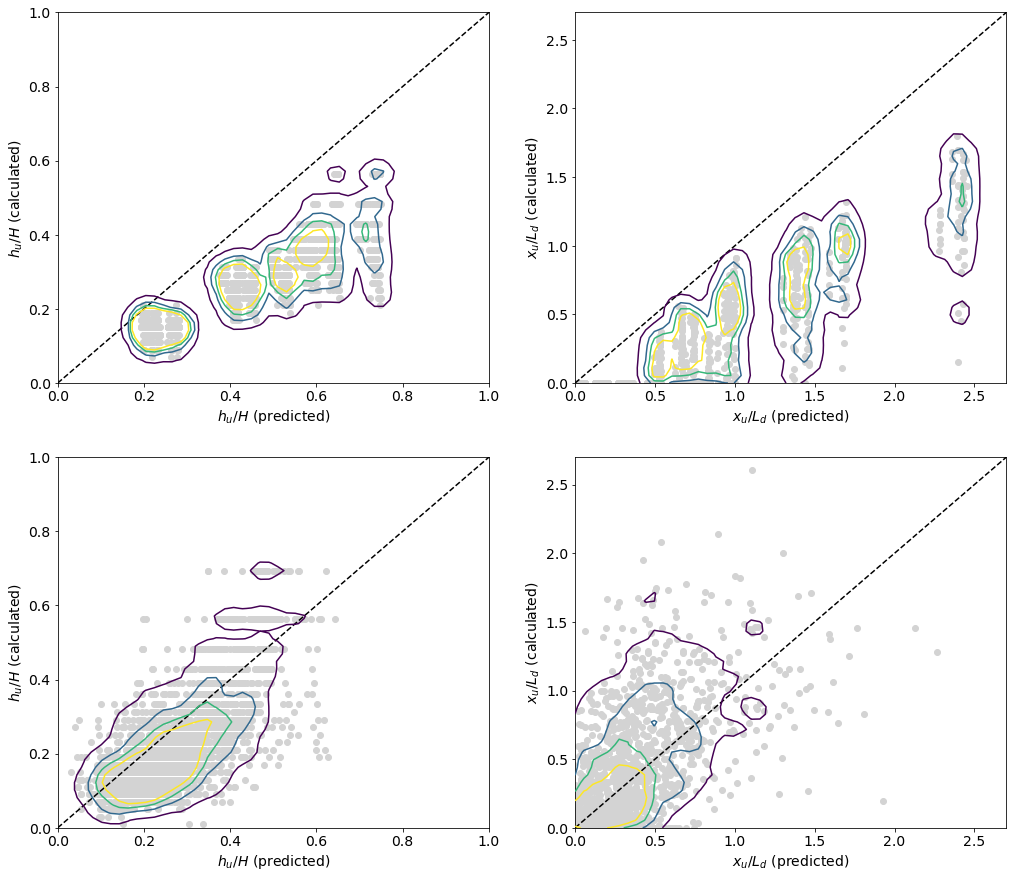

In [71]:
# Plot basic
fig, axs = plot_results(['H', 'L_d'], [1, 2.7])

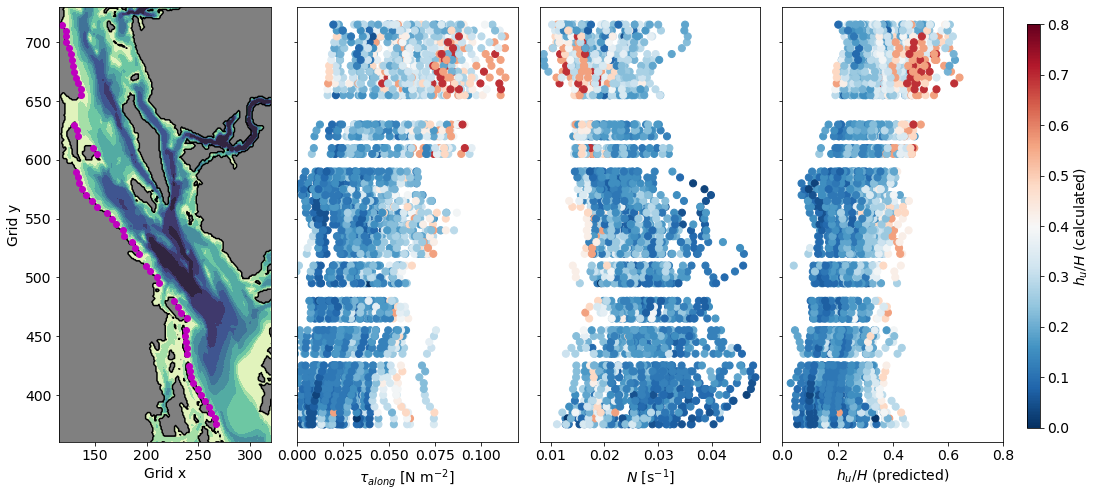

In [183]:
# Plot spatial
fig, axs = plot_spatial(runs_hindcast)

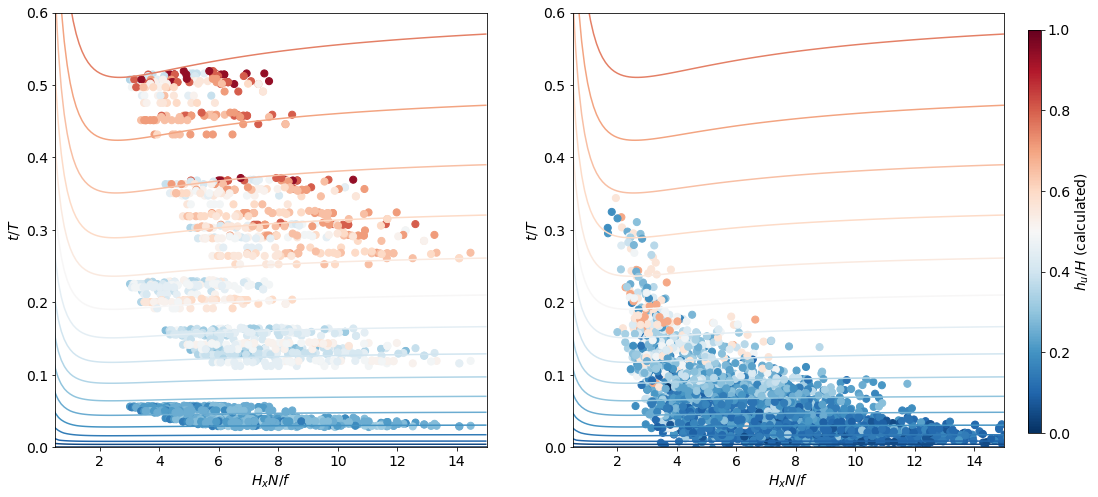

In [188]:
# Plot property space
fig, axs = plot_property_space()